## Libraries

In [1]:
import pandas as pd 
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
from neo4j import GraphDatabase
from pm4py.objects.log.log import EventLog
from collections import Counter
import pm4py
import matplotlib.pyplot as plt 
from pm4py.statistics.traces.log import case_statistics
from pm4py import stats
import plotly.graph_objects as go

## connection to Neo4J database

In [2]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "Croma2023"))
session = driver.session()

## Get cases from the graph database

In [3]:
query = f'''Match (e:Event) 
where not e:OnlyKitEvent and e.CaseID is not null
return e.CaseID, e.Activity, e.Nombre, e.KitID, e.Usuario as resource, e.timestamp, e.`Código`, e.NS '''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
df = pd.DataFrame(records, columns=columns)
df['e.timestamp'] = pd.to_datetime(df['e.timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
df.head()

e.CaseID              e.Activity          e.Nombre  \
0     HNB-OFT.002-10-CN31636  Entrada Material Sucio       Catarata 10   
1     HNB-OFT.002-19-CN31637  Entrada Material Sucio       Catarata 19   
2      HNB-CPL.002-5-CN31638  Entrada Material Sucio           Mano 05   
3       HNB-CG.001-7-CN31639  Entrada Material Sucio    Laparotomia 07   
4  EQP-QUI.OFT.002-3-CN31640  Entrada Material Sucio  FACO INFINITI 03   

             e.KitID resource               e.timestamp       e.`Código`  e.NS  
0     HNB-OFT.002-10      MMF 2022-03-31 20:30:00+00:00      HNB-OFT.002    10  
1     HNB-OFT.002-19      MMF 2022-03-31 20:30:00+00:00      HNB-OFT.002    19  
2      HNB-CPL.002-5      MMF 2022-03-31 20:30:00+00:00      HNB-CPL.002     5  
3       HNB-CG.001-7      MMF 2022-03-31 20:30:00+00:00       HNB-CG.001     7  
4  EQP-QUI.OFT.002-3      MMF 2022-03-31 20:30:00+00:00  EQP-QUI.OFT.002     3

In [4]:
df.count()

e.CaseID       227672
e.Activity     227672
e.Nombre       227672
e.KitID        227672
resource       227672
e.timestamp    227672
e.`Código`     227672
e.NS           227672
dtype: int64

## Start process discovery using PM4PY

### 1- Process discovery over the data without filters

In [5]:
event_log = pm4py.format_dataframe(df, case_id='e.CaseID', activity_key='e.Activity', timestamp_key='e.timestamp')
event_log = pm4py.convert_to_event_log(event_log)

In [6]:
len(pm4py.get_variants_as_tuples(event_log))

1982

In [7]:
dfStart = pd.DataFrame(list(pm4py.get_start_activities(event_log).items()), columns=['Activity', 'Count'])
dfStart.head()

Activity  Count
0                          Montaje   5821
1           Entrada Material Sucio  12022
2             Cargado en carro L+D   1329
3               Carga L+D iniciada    126
4  Carga de esterilizador liberada    111

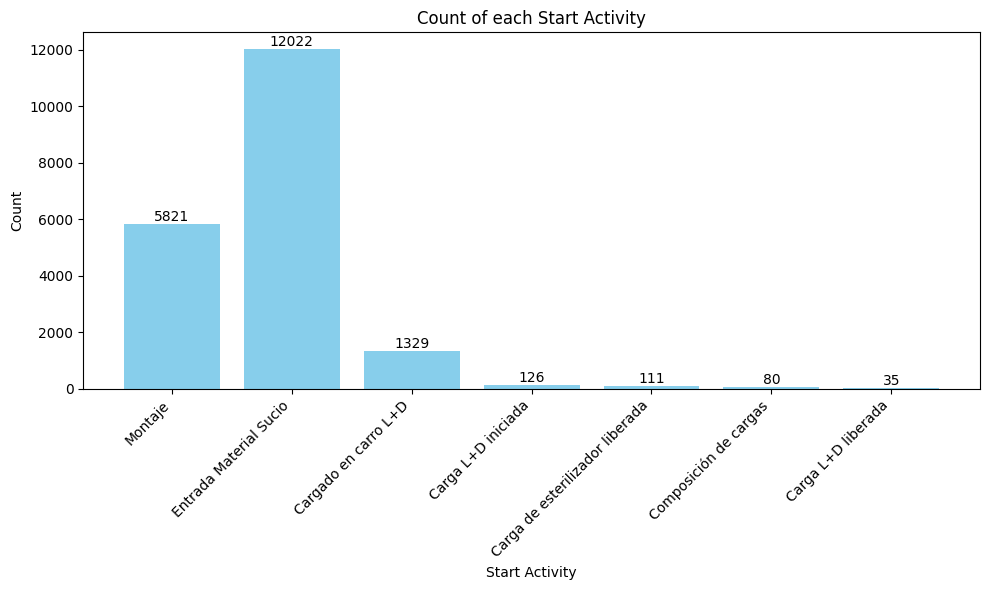

In [8]:
plt.figure(figsize=(10, 6))
bars = plt.bar(dfStart['Activity'], dfStart['Count'], color='skyblue')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, '%d' % int(height), ha='center', va='bottom')
plt.xlabel('Start Activity')
plt.ylabel('Count')
plt.title('Count of each Start Activity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [9]:
dfEnd = pd.DataFrame(list(pm4py.get_end_activities(event_log).items()), columns=['Activity', 'Count'])
dfEnd.head()

Activity  Count
0               Montaje     31
1    Producción montada     65
2    Carga L+D liberada   2924
3    Carga L+D iniciada    154
4  Cargado en carro L+D     64

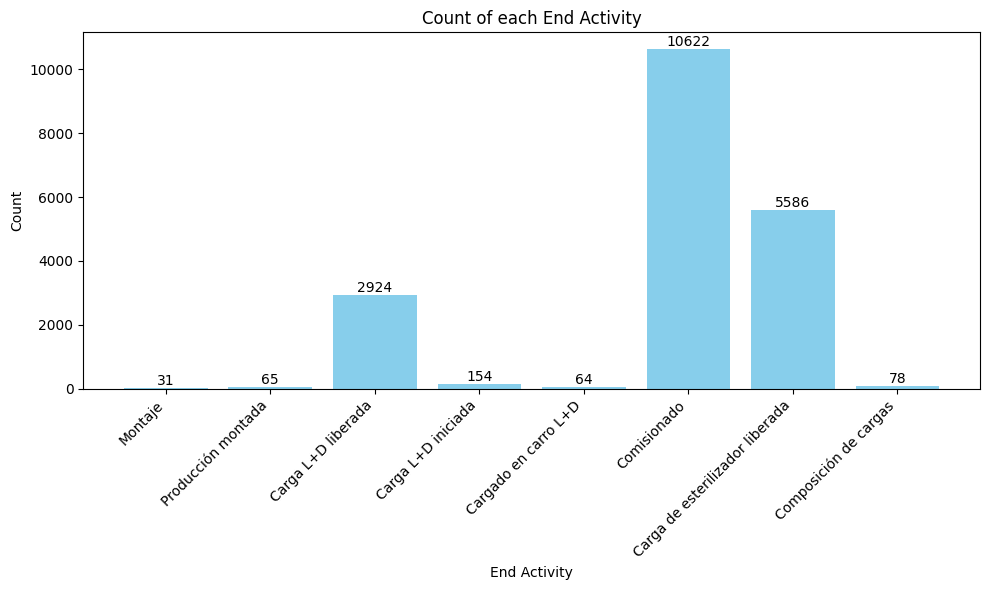

In [10]:
plt.figure(figsize=(10, 6))
bars = plt.bar(dfEnd['Activity'], dfEnd['Count'], color='skyblue')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, '%d' % int(height), ha='center', va='bottom')
plt.xlabel('End Activity')
plt.ylabel('Count')
plt.title('Count of each End Activity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [11]:
arrival_rate = stats.get_case_arrival_average(event_log) 
print("Average arrival rate in minutes:", arrival_rate / 60)

Average arrival rate in minutes: 6.605593402653281


In [12]:
median_case_duration = case_statistics.get_median_case_duration(event_log) 
print ('median_case_duration in minutes:', median_case_duration / 60)

median_case_duration in minutes: 295.0


In [13]:
variant_statistics = case_statistics.get_variant_statistics(event_log) 
variant_statistics

[{'variant': ('Entrada Material Sucio',
   'Cargado en carro L+D',
   'Carga L+D iniciada',
   'Carga L+D liberada',
   'Montaje',
   'Producción montada',
   'Composición de cargas',
   'Carga de esterilizador liberada'),
  'count': 3535},
 {'variant': ('Entrada Material Sucio',
   'Cargado en carro L+D',
   'Carga L+D iniciada',
   'Carga L+D liberada',
   'Montaje',
   'Producción montada',
   'Composición de cargas',
   'Carga de esterilizador liberada',
   'Comisionado'),
  'count': 3457},
 {'variant': ('Montaje',
   'Producción montada',
   'Composición de cargas',
   'Carga de esterilizador liberada',
   'Comisionado'),
  'count': 2462},
 {'variant': ('Entrada Material Sucio',
   'Cargado en carro L+D',
   'Carga L+D iniciada',
   'Carga L+D liberada'),
  'count': 2032},
 {'variant': ('Montaje',
   'Producción montada',
   'Producción montada',
   'Composición de cargas',
   'Composición de cargas',
   'Carga de esterilizador liberada',
   'Carga de esterilizador liberada',
   '

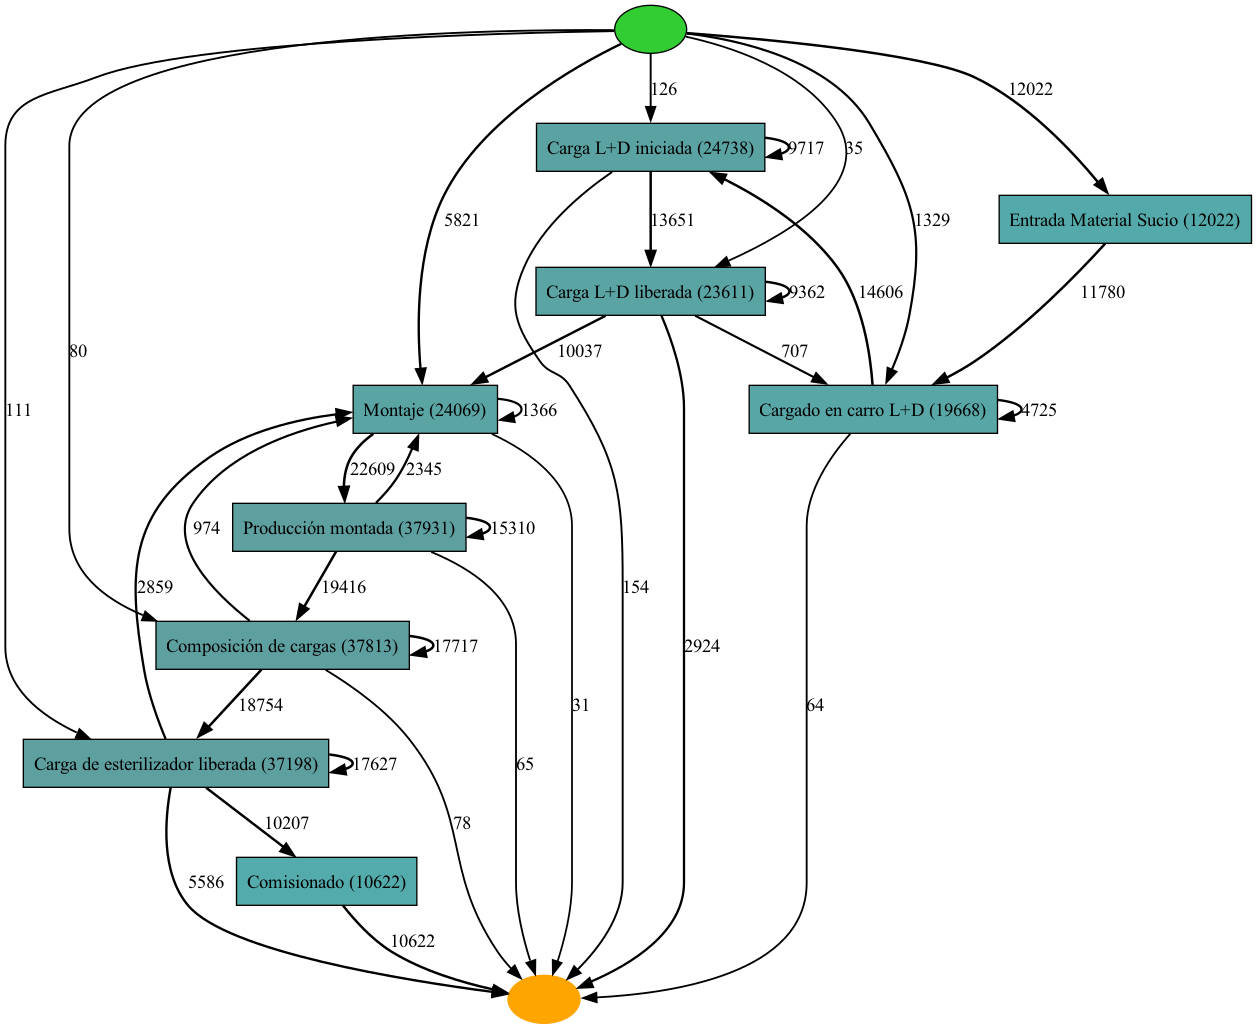

In [14]:
heu_net = pm4py.discover_heuristics_net(event_log, dependency_threshold=0.9)
pm4py.view_heuristics_net(heu_net)

### 2- Process discovery over the data with filter on the frequency of the trace

In [15]:
# Calculate trace frequencies
trace_frequency = Counter()
for trace in event_log:
    trace_id = tuple(event["concept:name"] for event in trace)
    trace_frequency[trace_id] += 1

In [16]:
# Define the minimum frequency threshold
min_frequency = 10  # Change this value to your desired minimum frequency

# Filter traces based on frequency
filtered_event_log = EventLog()
for trace in event_log:
    trace_id = tuple(event["concept:name"] for event in trace)
    if trace_frequency[trace_id] >= min_frequency:
        filtered_event_log.append(trace)

In [17]:
len(pm4py.get_variants_as_tuples(filtered_event_log))

101

In [18]:
median_case_duration = case_statistics.get_median_case_duration(filtered_event_log) 
print ('median_case_duration in minutes:', median_case_duration / 60)

median_case_duration in minutes: 282.0


In [19]:
pm4py.get_start_activities(filtered_event_log)

{'Montaje': 4605,
 'Entrada Material Sucio': 11315,
 'Cargado en carro L+D': 825,
 'Carga de esterilizador liberada': 74,
 'Composición de cargas': 44}

In [20]:
pm4py.get_end_activities(filtered_event_log)

{'Producción montada': 37,
 'Carga L+D liberada': 2768,
 'Carga L+D iniciada': 112,
 'Cargado en carro L+D': 45,
 'Comisionado': 8894,
 'Carga de esterilizador liberada': 4964,
 'Composición de cargas': 43}

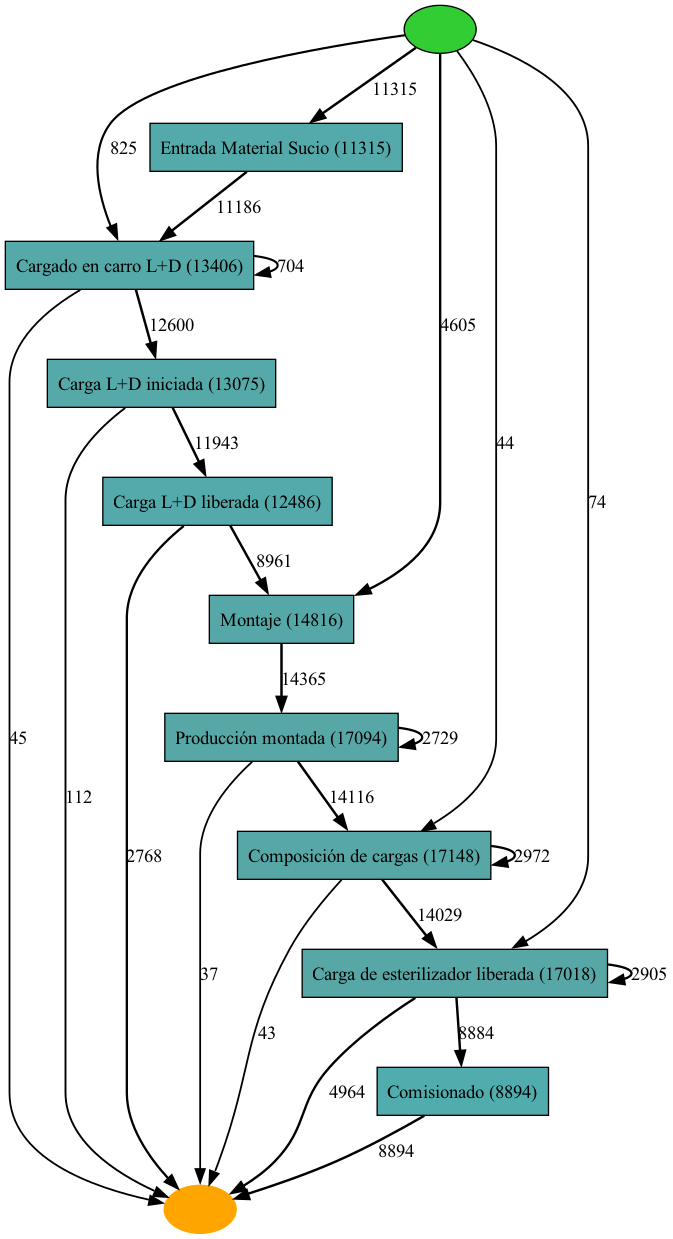

In [21]:
heu_net = pm4py.discover_heuristics_net(filtered_event_log, dependency_threshold=0.9)
pm4py.view_heuristics_net(heu_net)

## Statistics about the process flow

In [22]:
filtered_df = pm4py.convert_to_dataframe(filtered_event_log)
filtered_df.head()

concept:name                        e.Nombre          e.KitID  \
0                 Montaje  Pinza Duckling Right 45          012047 L2901-0   
1      Producción montada  Pinza Duckling Right 45          012047 L2901-0   
2  Entrada Material Sucio               *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1   
3    Cargado en carro L+D               *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1   
4      Carga L+D iniciada               *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1   

  resource            time:timestamp     e.`Código`  e.NS  @@index  \
0       ER 2022-01-18 19:11:00+00:00   012047 L2901     0   100402   
1       ER 2022-01-18 19:11:00+00:00   012047 L2901     0   136172   
2       ER 2022-01-28 13:10:00+00:00  CONT-CCEE.ALE     1     8930   
3       ER 2022-01-28 13:18:00+00:00  CONT-CCEE.ALE     1    25065   
4      MMF 2022-01-28 13:34:00+00:00  CONT-CCEE.ALE     1    48053   

         case:concept:name  
0    012047 L2901-0-CN6749  
1    012047 L2901-0-CN6749  
2  CONT-CCEE.ALE-1-CN11541  
3  CONT-CCEE.ALE-1-CN11541  
4  CONT-CCEE.ALE-1-CN11541

In [23]:
segments = []
df = filtered_df.sort_values(['case:concept:name', 'time:timestamp', 'concept:name'])

result = pd.concat([df, df.shift(-1)], axis=1)
result.columns = [str(i) + str(k // (len(df.columns))) for k, i in enumerate(result.columns)]
result = result[result['case:concept:name0'] == result['case:concept:name1']]

result['segment_name'] = result['concept:name0'] + ' - ' + result['concept:name1']
result.drop(['concept:name0', 'case:concept:name1', 'concept:name1'], axis=1, inplace=True)
result.columns = ['start_' + i.split('0')[0] if '0' in i else ('end_' + i.split('1')[0] if '1' in i else i) for i in result.columns]

segments = result['segment_name'].unique()
result.head()

start_e.Nombre    start_e.KitID start_resource  \
0  Pinza Duckling Right 45          012047 L2901-0             ER   
2               *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1             ER   
3               *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1             ER   
4               *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1            MMF   
6               *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1             ER   

       start_time:timestamp start_e.`Código`  start_e.NS  start_@@index  \
0 2022-01-18 19:11:00+00:00     012047 L2901           0         100402   
2 2022-01-28 13:10:00+00:00    CONT-CCEE.ALE           1           8930   
3 2022-01-28 13:18:00+00:00    CONT-CCEE.ALE           1          25065   
4 2022-01-28 13:34:00+00:00    CONT-CCEE.ALE           1          48053   
6 2022-01-05 13:26:00+00:00    CONT-CCEE.ALE           1          11687   

   start_case:concept:name                    end_e.Nombre      end_e.KitID  \
0    012047 L2901-0-CN6749  Pinza Duckling Right 45          012047 L2901-0   
2  CONT-CCEE.ALE-1-CN11541               *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1   
3  CONT-CCEE.ALE-1-CN11541               *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1   
4  CONT-CCEE.ALE-1-CN11541               *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1   
6   CONT-CCEE.ALE-1-CN1395               *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1   

  end_resource        end_time:timestamp end_e.`Código`  end_e.NS  \
0           ER 2022-01-18 19:11:00+00:00   012047 L2901       0.0   
2           ER 2022-01-28 13:18:00+00:00  CONT-CCEE.ALE       1.0   
3          MMF 2022-01-28 13:34:00+00:00  CONT-CCEE.ALE       1.0   
4          MCE 2022-01-28 14:39:00+00:00  CONT-CCEE.ALE       1.0   
6           ER 2022-01-05 13:29:00+00:00  CONT-CCEE.ALE       1.0   

   end_@@index                                   segment_name  
0     136172.0                   Montaje - Producción montada  
2      25065.0  Entrada Material Sucio - Cargado en carro L+D  
3      48053.0      Cargado en carro L+D - Carga L+D iniciada  
4      71906.0        Carga L+D iniciada - Carga L+D liberada  
6      30852.0  Entrada Material Sucio - Cargado en carro L+D

### 1- Over all statistics

In [24]:
result['durationMinutes'] = (result['end_time:timestamp'] - result['start_time:timestamp']).dt.total_seconds() / 60 

In [25]:
# Calculate Q1, Q3, and IQR
Q1 = result.groupby('segment_name')['durationMinutes'].quantile(0.25)
Q3 = result.groupby('segment_name')['durationMinutes'].quantile(0.75)
IQR = Q3 - Q1

# Calculate lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
result_filtered = result[~result.apply(lambda x: (x['durationMinutes'] < lower_bound[x['segment_name']]) or 
                                              (x['durationMinutes'] > upper_bound[x['segment_name']]), axis=1)]

# Group by segment_name and calculate statistics
grouped = result_filtered.groupby('segment_name')['durationMinutes'].describe()

grouped.head()

                                                      count         mean  \
segment_name                                                               
Carga L+D iniciada - Carga L+D iniciada               363.0    20.498623   
Carga L+D iniciada - Carga L+D liberada              9938.0    69.263232   
Carga L+D iniciada - Cargado en carro L+D            1001.0     0.000000   
Carga L+D iniciada - Montaje                           70.0    13.628571   
Carga L+D liberada - Carga L+D iniciada                48.0   944.687500   
Carga L+D liberada - Carga L+D liberada               408.0    31.193627   
Carga L+D liberada - Cargado en carro L+D             261.0  1641.835249   
Carga L+D liberada - Composición de cargas             22.0    15.727273   
Carga L+D liberada - Montaje                         8406.0    26.864858   
Carga de esterilizador liberada - Carga L+D ini...     22.0   522.181818   
Carga de esterilizador liberada - Carga de este...   2898.0     0.000000   
Carga de est

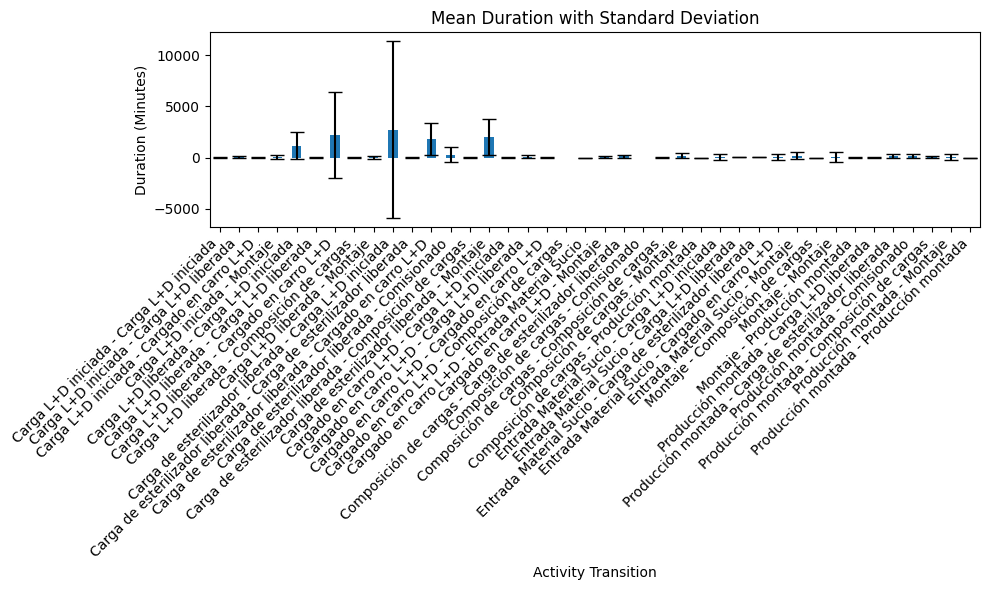

In [26]:
result['durationMinutes'] = (result['end_time:timestamp'] - result['start_time:timestamp']).dt.total_seconds() / 60 
grouped = result.groupby(['segment_name'])['durationMinutes'].describe()

# Plotting mean with error bars (standard deviation)
plt.figure(figsize=(10, 6))
grouped['mean'].plot(kind='bar', yerr=grouped['std'], capsize=5)
plt.xlabel('Activity Transition')
plt.ylabel('Duration (Minutes)')
plt.title('Mean Duration with Standard Deviation')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [27]:
result.head()

start_e.Nombre    start_e.KitID start_resource  \
0  Pinza Duckling Right 45          012047 L2901-0             ER   
2               *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1             ER   
3               *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1             ER   
4               *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1            MMF   
6               *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1             ER   

       start_time:timestamp start_e.`Código`  start_e.NS  start_@@index  \
0 2022-01-18 19:11:00+00:00     012047 L2901           0         100402   
2 2022-01-28 13:10:00+00:00    CONT-CCEE.ALE           1           8930   
3 2022-01-28 13:18:00+00:00    CONT-CCEE.ALE           1          25065   
4 2022-01-28 13:34:00+00:00    CONT-CCEE.ALE           1          48053   
6 2022-01-05 13:26:00+00:00    CONT-CCEE.ALE           1          11687   

   start_case:concept:name                    end_e.Nombre      end_e.KitID  \
0    012047 L2901-0-CN6749  Pinza Duckling Right 45          012047 L2901-0   
2  CONT-CCEE.ALE-1-CN11541               *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1   
3  CONT-CCEE.ALE-1-CN11541               *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1   
4  CONT-CCEE.ALE-1-CN11541               *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1   
6   CONT-CCEE.ALE-1-CN1395               *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1   

  end_resource        end_time:timestamp end_e.`Código`  end_e.NS  \
0           ER 2022-01-18 19:11:00+00:00   012047 L2901       0.0   
2           ER 2022-01-28 13:18:00+00:00  CONT-CCEE.ALE       1.0   
3          MMF 2022-01-28 13:34:00+00:00  CONT-CCEE.ALE       1.0   
4          MCE 2022-01-28 14:39:00+00:00  CONT-CCEE.ALE       1.0   
6           ER 2022-01-05 13:29:00+00:00  CONT-CCEE.ALE       1.0   

   end_@@index                                   segment_name  durationMinutes  
0     136172.0                   Montaje - Producción montada              0.0  
2      25065.0  Entrada Material Sucio - Cargado en carro L+D              8.0  
3      48053.0      Cargado en carro L+D - Carga L+D iniciada             16.0  
4      71906.0        Carga L+D iniciada - Carga L+D liberada             65.0  
6      30852.0  Entrada Material Sucio - Cargado en carro L+D              3.0

In [28]:
grouped.head()

count         mean          std  \
segment_name                                                                   
Carga L+D iniciada - Carga L+D iniciada      391.0    29.601023    41.012936   
Carga L+D iniciada - Carga L+D liberada    11256.0    82.878820    82.985935   
Carga L+D iniciada - Cargado en carro L+D   1241.0     5.041096    23.266217   
Carga L+D iniciada - Montaje                  80.0    46.787500   205.471159   
Carga L+D liberada - Carga L+D iniciada       51.0  1169.215686  1344.091088   

                                           min   25%     50%      75%     max  
segment_name                                                                   
Carga L+D iniciada - Carga L+D iniciada    0.0   3.0    13.0    38.00   195.0  
Carga L+D iniciada - Carga L+D liberada    0.0  63.0    70.0    77.00   826.0  
Carga L+D iniciada - Cargado en carro L+D  0.0   0.0     0.0     0.00   602.0  
Carga L+D iniciada - Montaje               1.0   4.0    10.5    24.75  1836.0  
Carga L+D liberada - Carga L+D iniciada    2.0  23.0  1112.0  1532.50  5735.0

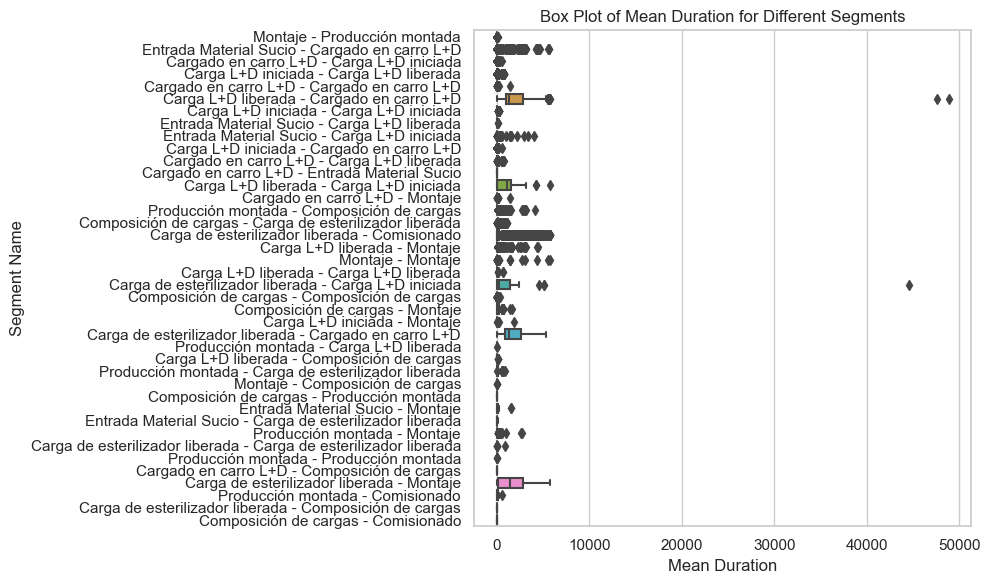

In [29]:
sns.set(style="whitegrid")

# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=result['durationMinutes'], y=result['segment_name'], showfliers=True)
plt.xlabel('Mean Duration')
plt.ylabel('Segment Name')
plt.title('Box Plot of Mean Duration for Different Segments')
plt.tight_layout()
plt.show()

### 2- add frequency filter, to filter incidences less that 100 time

In [30]:
freq = grouped[grouped['count'] > 100]
freq.head()

count         mean          std  \
segment_name                                                                   
Carga L+D iniciada - Carga L+D iniciada      391.0    29.601023    41.012936   
Carga L+D iniciada - Carga L+D liberada    11256.0    82.878820    82.985935   
Carga L+D iniciada - Cargado en carro L+D   1241.0     5.041096    23.266217   
Carga L+D liberada - Carga L+D liberada      413.0    34.786925    48.218235   
Carga L+D liberada - Cargado en carro L+D    278.0  2192.061151  4217.139463   

                                           min     25%     50%     75%  \
segment_name                                                             
Carga L+D iniciada - Carga L+D iniciada    0.0     3.0    13.0    38.0   
Carga L+D iniciada - Carga L+D liberada    0.0    63.0    70.0    77.0   
Carga L+D iniciada - Cargado en carro L+D  0.0     0.0     0.0     0.0   
Carga L+D liberada - Carga L+D liberada    0.0    13.0    26.0    49.0   
Carga L+D liberada - Cargado en carro L+D  0.0  1027.0  1360.0  2799.5   

                                               max  
segment_name                                        
Carga L+D iniciada - Carga L+D iniciada      195.0  
Carga L+D iniciada - Carga L+D liberada      826.0  
Carga L+D iniciada - Cargado en carro L+D    602.0  
Carga L+D liberada - Carga L+D liberada      640.0  
Carga L+D liberada - Cargado en carro L+D  48853.0

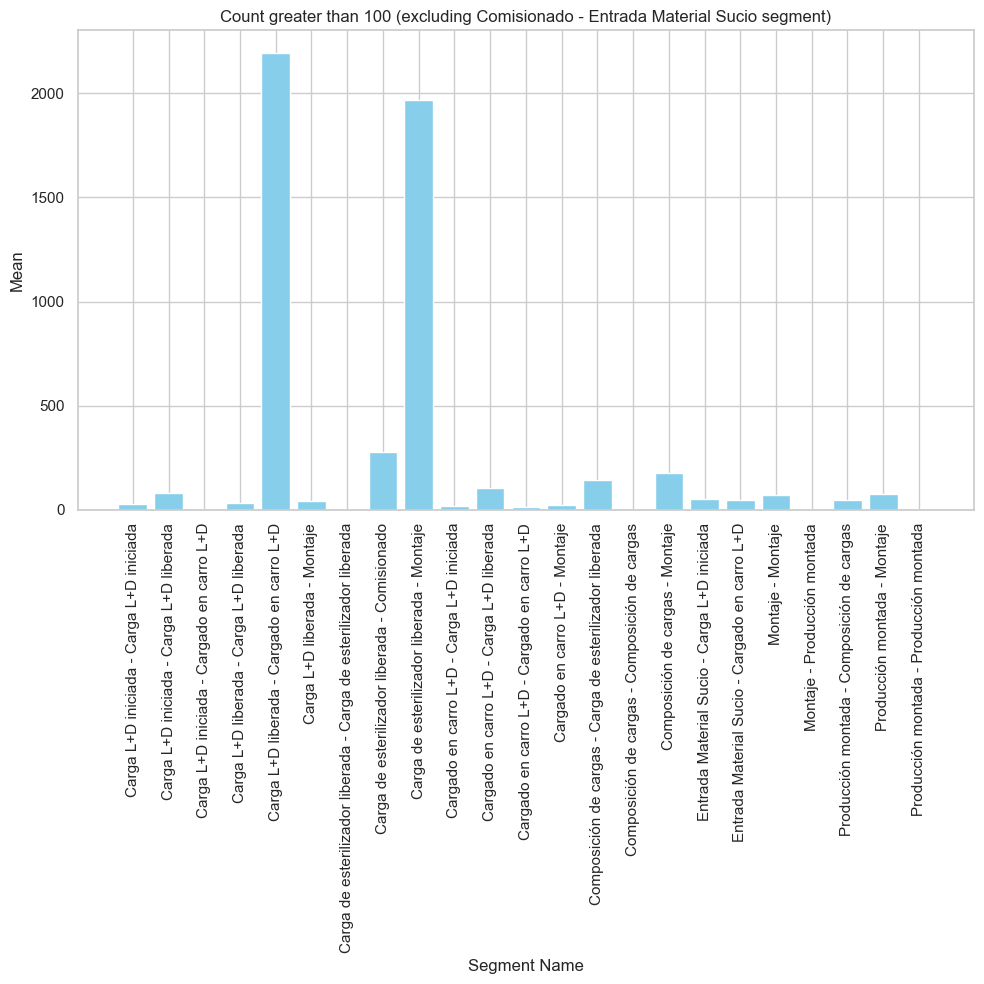

In [31]:
# Exclude a single segment by specifying its index or label
segment_to_exclude = 'Comisionado - Entrada Material Sucio'

# Filter the DataFrame to include only segments other than the one to exclude
filtered_df_excluded = freq[freq.index != segment_to_exclude]

# Plot the filtered data excluding the single segment
plt.figure(figsize=(10, 10))
plt.bar(filtered_df_excluded.index, filtered_df_excluded['mean'], color='skyblue')
plt.xlabel('Segment Name')
plt.ylabel('Mean')
plt.title('Count greater than 100 (excluding Comisionado - Entrada Material Sucio segment)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

### 3- Plot the data including a specified segments

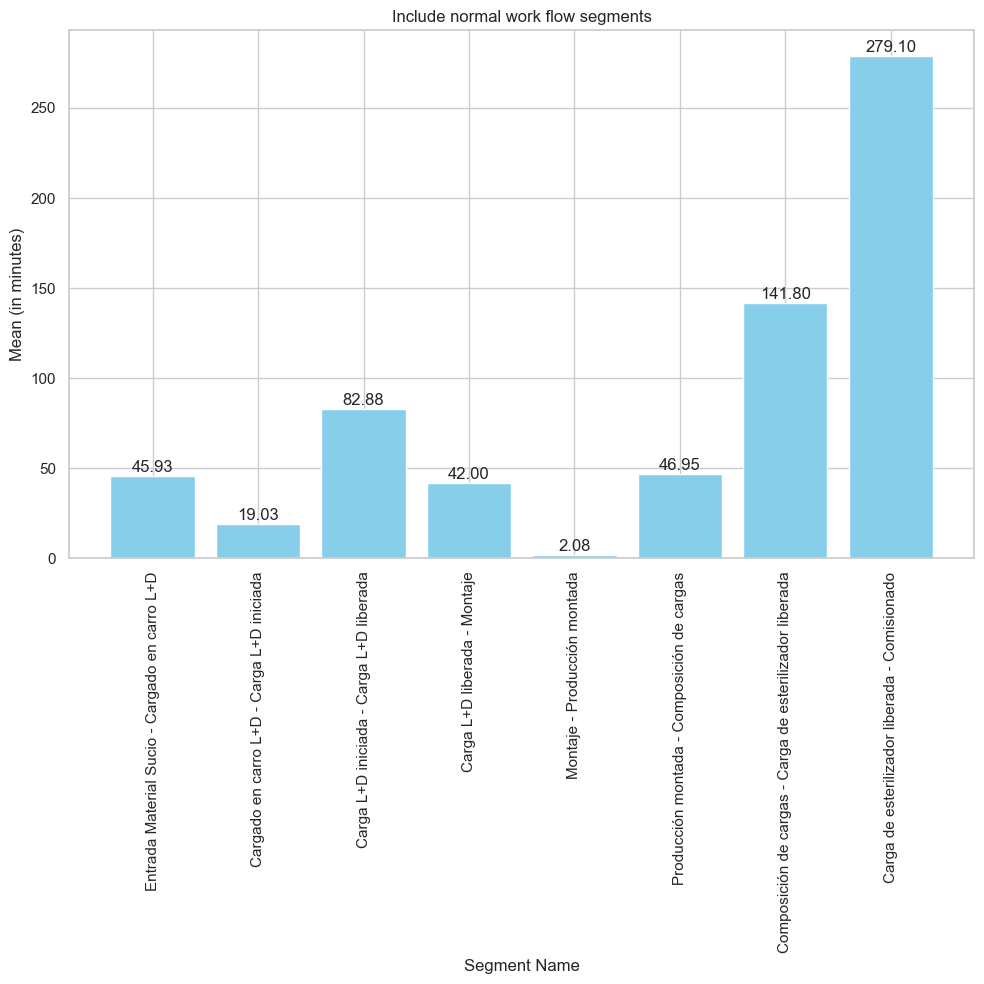

In [32]:
# Define the segments to include
segments_work_flow = ['Entrada Material Sucio - Cargado en carro L+D',
                        'Cargado en carro L+D - Carga L+D iniciada',
                         'Carga L+D iniciada - Carga L+D liberada',
                          'Carga L+D liberada - Montaje',
                           'Montaje - Producción montada',
                            'Producción montada - Composición de cargas',
                             'Composición de cargas - Carga de esterilizador liberada',
                              'Carga de esterilizador liberada - Comisionado']

filtered_df_included = grouped[grouped.index.isin(segments_work_flow)]
filtered_df_included = filtered_df_included.loc[segments_work_flow]

plt.figure(figsize=(10, 10))
bars = plt.bar(filtered_df_included.index, filtered_df_included['mean'], color='skyblue')

for bar, mean in zip(bars, filtered_df_included['mean']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{mean:.2f}', ha='center', va='bottom')

plt.xlabel('Segment Name')
plt.ylabel('Mean (in minutes)')
plt.title('Include normal work flow segments')
plt.xticks(rotation=90)  
plt.tight_layout()
plt.show()

In [33]:
filtered_df_included.head(10)

count        mean  \
segment_name                                                              
Entrada Material Sucio - Cargado en carro L+D       10417.0   45.926754   
Cargado en carro L+D - Carga L+D iniciada           11680.0   19.028168   
Carga L+D iniciada - Carga L+D liberada             11256.0   82.878820   
Carga L+D liberada - Montaje                         8950.0   41.997207   
Montaje - Producción montada                        14342.0    2.083531   
Producción montada - Composición de cargas          14057.0   46.952337   
Composición de cargas - Carga de esterilizador ...  13971.0  141.797294   
Carga de esterilizador liberada - Comisionado        8883.0  279.097377   

                                                           std  min   25%  \
segment_name                                                                
Entrada Material Sucio - Cargado en carro L+D       265.381892  1.0   9.0   
Cargado en carro L+D - Carga L+D iniciada            25.032066  1.0   3.0   
Carga L+D iniciada - Carga L+D liberada              82.985935  0.0  63.0   
Carga L+D liberada - Montaje                        135.611769  0.0  10.0   
Montaje - Producción montada                          4.223713  0.0   0.0   
Producción montada - Composición de cargas          101.387017  1.0  11.0   
Composición de cargas - Carga de esterilizador ...  143.240905  6.0  85.0   
Carga de esterilizador liberada - Comisionado       710.034699  0.0  17.0   

                                                      50%    75%     max  
segment_name                                                              
Entrada Material Sucio - Cargado en carro L+D        15.0   24.0  5648.0  
Cargado en carro L+D - Carga L+D iniciada            10.0   28.0   591.0  
Carga L+D iniciada - Carga L+D liberada              70.0   77.0   826.0  
Carga L+D liberada - Montaje                         22.0   45.0  4423.0  
Montaje - Producción montada                          0.0    2.0    98.0  
Producción montada - Composición de cargas           25.0   54.0  4103.0  
Composición de cargas - Carga de esterilizador ...  101.0  117.0  1106.0  
Carga de esterilizador liberada - Comisionado        56.0  222.0  5756.0

In [77]:
total_row = filtered_df_included.sum(axis=0)
total_row['segment_name'] = 'Total'

# Append the total row to the DataFrame
df_with_total = filtered_df_included.append(total_row, ignore_index=True)

df_with_total.head(10)

count        mean         std   min     25%    50%     75%     max
0   786.0   52.966921  266.392013   1.0    6.00   13.0   21.00  4070.0
1   742.0  102.269542  131.062934   1.0   60.00   70.0   80.00   762.0
2    80.0   46.787500  205.471159   1.0    4.00   10.5   24.75  1836.0
3    23.0    2.217391    2.354040   1.0    1.00    1.0    2.00    10.0
4    58.0  163.517241  196.719610   4.0   74.25   88.5  115.00   901.0
5     1.0    4.000000         NaN   4.0    4.00    4.0    4.00     4.0
6  1690.0  371.758596  801.999756  12.0  149.25  187.0  246.75  7583.0

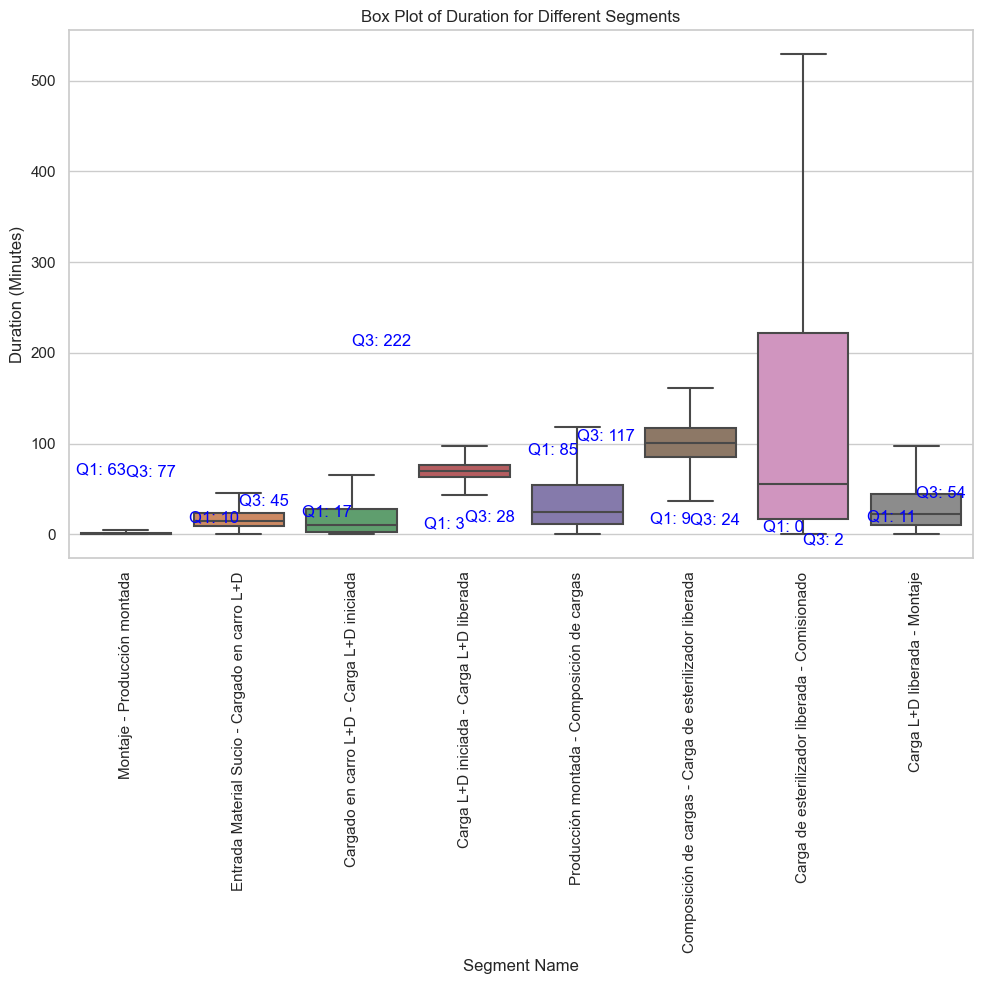

In [35]:
filtered_data = result[result['segment_name'].isin(segments_work_flow)]

# Calculate statistics
grouped_data = filtered_data.groupby('segment_name')['durationMinutes']
statistics = grouped_data.describe(percentiles=[.25, .75])[['std', '25%', '75%']].reset_index()

sns.set(style="whitegrid")

# Create the box plot
plt.figure(figsize=(10, 10))
sns.boxplot(x='segment_name', y='durationMinutes', data=filtered_data, showfliers= False)
plt.xlabel('Segment Name')
plt.ylabel('Duration (Minutes)')
plt.title('Box Plot of Duration for Different Segments')

# Add standard deviation (std), 25th percentile (Q1), and 75th percentile (Q3) annotations
for i in range(len(statistics)):
    segment_name = statistics.loc[i, 'segment_name']
    #std = statistics.loc[i, 'std']
    q1 = statistics.loc[i, '25%']
    q3 = statistics.loc[i, '75%']
    plt.text(i, q1, f'Q1: {q1:.0f}', ha='right', va='bottom', color='blue')
    plt.text(i, q3, f'Q3: {q3:.0f}', ha='left', va='top', color='blue')
    #plt.text(i, q1 - 0.5*std, f'Std: {std:.0f}', ha='center', va='top', color='red')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [36]:
filtered_data.head()

start_e.Nombre    start_e.KitID start_resource  \
0  Pinza Duckling Right 45          012047 L2901-0             ER   
2               *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1             ER   
3               *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1             ER   
4               *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1            MMF   
6               *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1             ER   

       start_time:timestamp start_e.`Código`  start_e.NS  start_@@index  \
0 2022-01-18 19:11:00+00:00     012047 L2901           0         100402   
2 2022-01-28 13:10:00+00:00    CONT-CCEE.ALE           1           8930   
3 2022-01-28 13:18:00+00:00    CONT-CCEE.ALE           1          25065   
4 2022-01-28 13:34:00+00:00    CONT-CCEE.ALE           1          48053   
6 2022-01-05 13:26:00+00:00    CONT-CCEE.ALE           1          11687   

   start_case:concept:name                    end_e.Nombre      end_e.KitID  \
0    012047 L2901-0-CN6749  Pinza Duckling Right 45          012047 L2901-0   
2  CONT-CCEE.ALE-1-CN11541               *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1   
3  CONT-CCEE.ALE-1-CN11541               *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1   
4  CONT-CCEE.ALE-1-CN11541               *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1   
6   CONT-CCEE.ALE-1-CN1395               *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1   

  end_resource        end_time:timestamp end_e.`Código`  end_e.NS  \
0           ER 2022-01-18 19:11:00+00:00   012047 L2901       0.0   
2           ER 2022-01-28 13:18:00+00:00  CONT-CCEE.ALE       1.0   
3          MMF 2022-01-28 13:34:00+00:00  CONT-CCEE.ALE       1.0   
4          MCE 2022-01-28 14:39:00+00:00  CONT-CCEE.ALE       1.0   
6           ER 2022-01-05 13:29:00+00:00  CONT-CCEE.ALE       1.0   

   end_@@index                                   segment_name  durationMinutes  
0     136172.0                   Montaje - Producción montada              0.0  
2      25065.0  Entrada Material Sucio - Cargado en carro L+D              8.0  
3      48053.0      Cargado en carro L+D - Carga L+D iniciada             16.0  
4      71906.0        Carga L+D iniciada - Carga L+D liberada             65.0  
6      30852.0  Entrada Material Sucio - Cargado en carro L+D              3.0

### 4- Plot the data including tasks skipping one in between

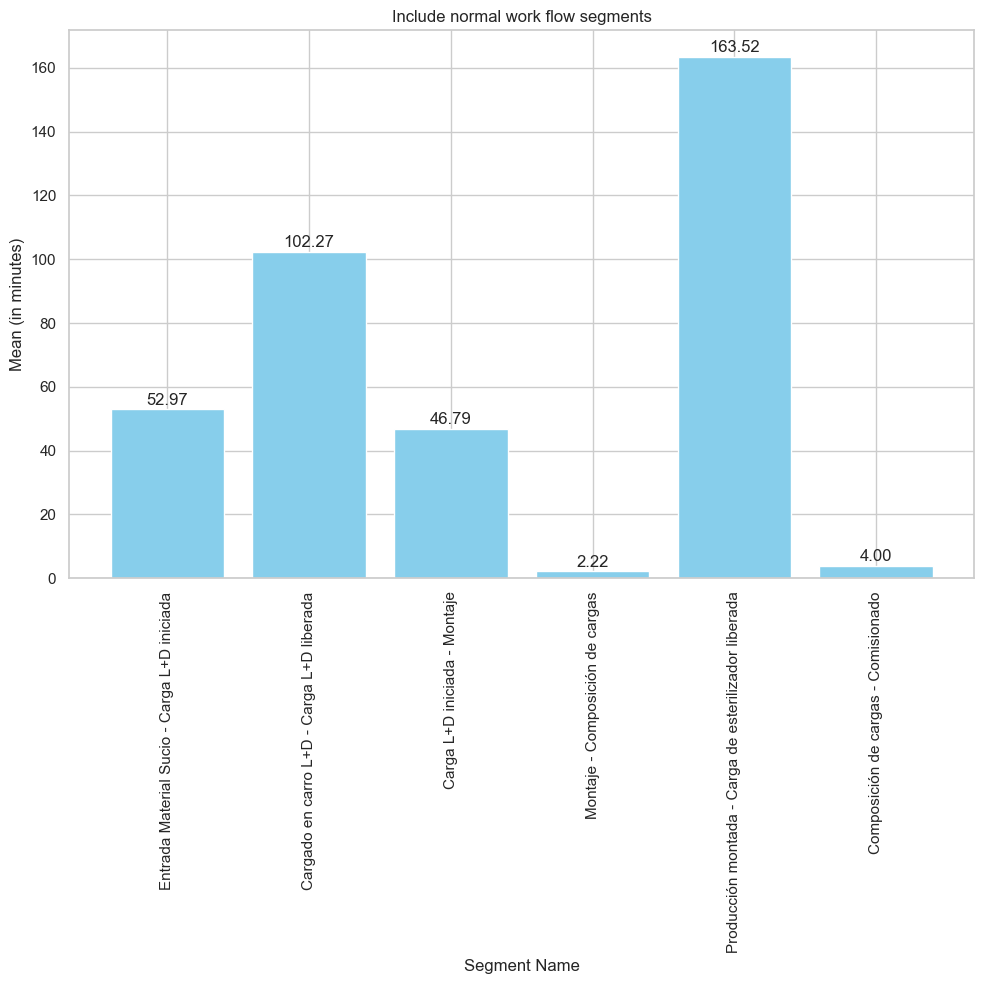

In [37]:
# Define the segments to include
segments_to_include = ['Entrada Material Sucio - Carga L+D iniciada',
                        'Cargado en carro L+D - Carga L+D liberada',
                         'Carga L+D iniciada - Montaje',
                           'Montaje - Composición de cargas',
                            'Producción montada - Carga de esterilizador liberada',
                             'Composición de cargas - Comisionado']

filtered_df_included = grouped[grouped.index.isin(segments_to_include)]
filtered_df_included = filtered_df_included.loc[segments_to_include]

plt.figure(figsize=(10, 10))
bars = plt.bar(filtered_df_included.index, filtered_df_included['mean'], color='skyblue')

for bar, mean in zip(bars, filtered_df_included['mean']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{mean:.2f}', ha='center', va='bottom')

plt.xlabel('Segment Name')
plt.ylabel('Mean (in minutes)')
plt.title('Include normal work flow segments')
plt.xticks(rotation=90)  
plt.tight_layout()
plt.show()

In [38]:
filtered_df_included.head()

count        mean  \
segment_name                                                            
Entrada Material Sucio - Carga L+D iniciada         786.0   52.966921   
Cargado en carro L+D - Carga L+D liberada           742.0  102.269542   
Carga L+D iniciada - Montaje                         80.0   46.787500   
Montaje - Composición de cargas                      23.0    2.217391   
Producción montada - Carga de esterilizador lib...   58.0  163.517241   

                                                           std  min    25%  \
segment_name                                                                 
Entrada Material Sucio - Carga L+D iniciada         266.392013  1.0   6.00   
Cargado en carro L+D - Carga L+D liberada           131.062934  1.0  60.00   
Carga L+D iniciada - Montaje                        205.471159  1.0   4.00   
Montaje - Composición de cargas                       2.354040  1.0   1.00   
Producción montada - Carga de esterilizador lib...  196.719610  4.0  74.25   

                                                     50%     75%     max  
segment_name                                                              
Entrada Material Sucio - Carga L+D iniciada         13.0   21.00  4070.0  
Cargado en carro L+D - Carga L+D liberada           70.0   80.00   762.0  
Carga L+D iniciada - Montaje                        10.5   24.75  1836.0  
Montaje - Composición de cargas                      1.0    2.00    10.0  
Producción montada - Carga de esterilizador lib...  88.5  115.00   901.0

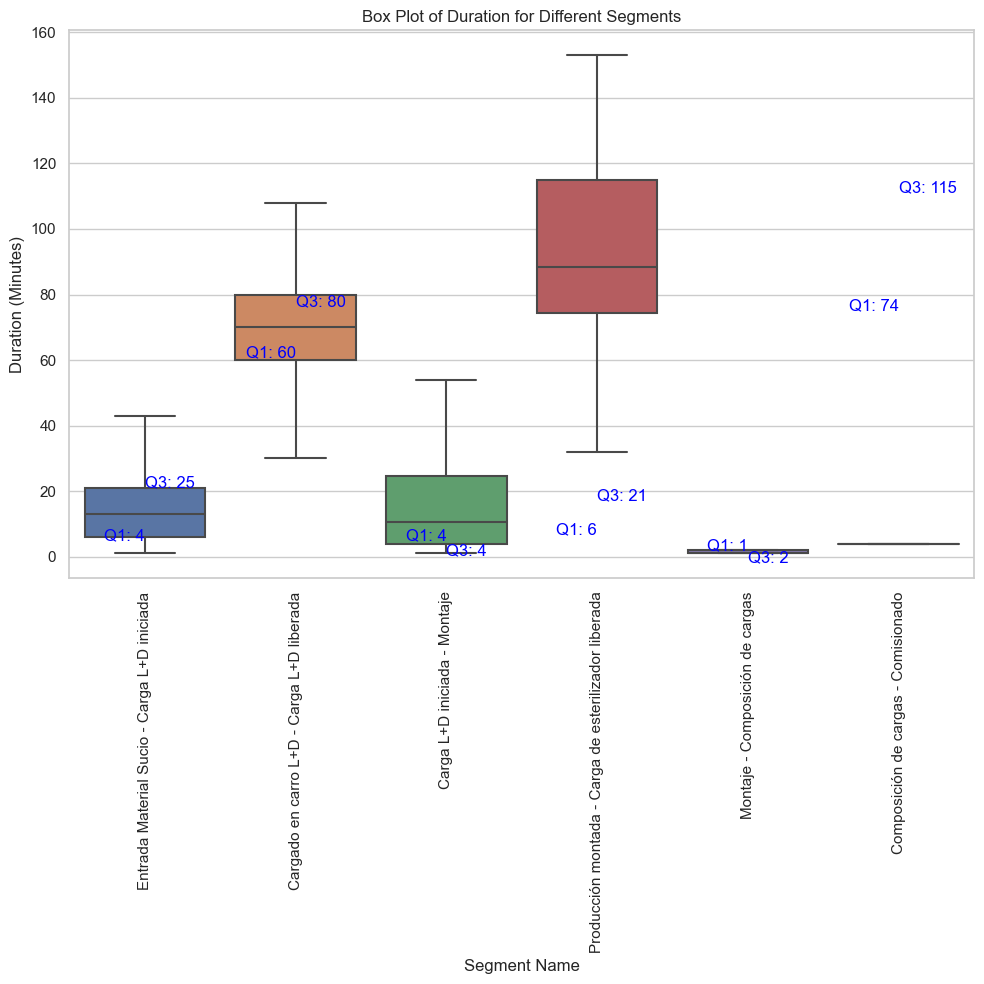

In [39]:
filtered_data = result[result['segment_name'].isin(segments_to_include)]

# Calculate statistics
grouped_data = filtered_data.groupby('segment_name')['durationMinutes']
statistics = grouped_data.describe(percentiles=[.25, .75])[['std', '25%', '75%']].reset_index()

sns.set(style="whitegrid")

# Create the box plot
plt.figure(figsize=(10, 10))
sns.boxplot(x='segment_name', y='durationMinutes', data=filtered_data, showfliers= False)
plt.xlabel('Segment Name')
plt.ylabel('Duration (Minutes)')
plt.title('Box Plot of Duration for Different Segments')

# Add standard deviation (std), 25th percentile (Q1), and 75th percentile (Q3) annotations
for i in range(len(statistics)):
    segment_name = statistics.loc[i, 'segment_name']
    #std = statistics.loc[i, 'std']
    q1 = statistics.loc[i, '25%']
    q3 = statistics.loc[i, '75%']
    plt.text(i, q1, f'Q1: {q1:.0f}', ha='right', va='bottom', color='blue')
    plt.text(i, q3, f'Q3: {q3:.0f}', ha='left', va='top', color='blue')
    #plt.text(i, q1 - 0.5*std, f'Std: {std:.0f}', ha='center', va='top', color='red')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [40]:
statistics.head()

segment_name         std   25%    75%
0                 Carga L+D iniciada - Montaje  205.471159   4.0  24.75
1    Cargado en carro L+D - Carga L+D liberada  131.062934  60.0  80.00
2          Composición de cargas - Comisionado         NaN   4.0   4.00
3  Entrada Material Sucio - Carga L+D iniciada  266.392013   6.0  21.00
4              Montaje - Composición de cargas    2.354040   1.0   2.00

### 5- Exclude the normal process flow

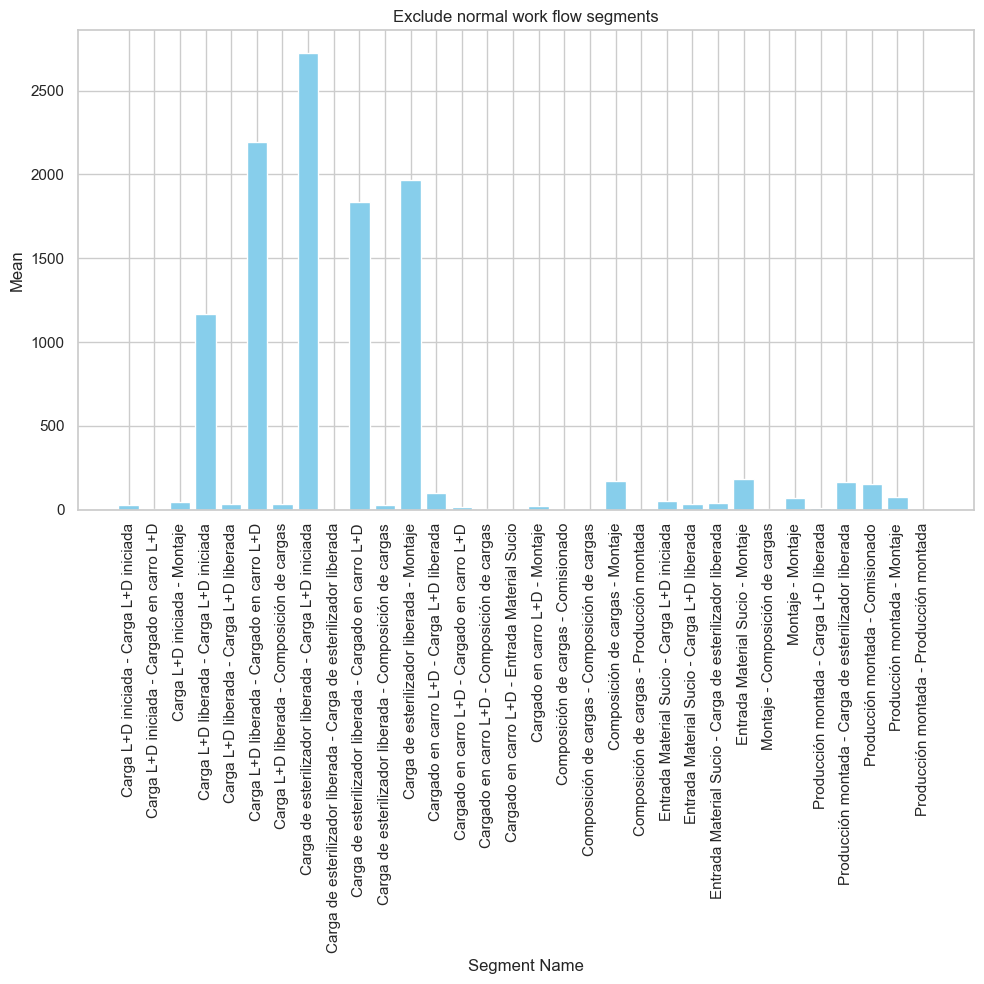

In [41]:
# Filter the DataFrame to include only segments not in the exclusion list
filtered_df_excluded = filtered_df[~filtered_df.index.isin(segments_work_flow)]

filtered_df_excluded = grouped[~grouped.index.isin(segments_work_flow)]

# Plot the filtered data excluding the specified segments
plt.figure(figsize=(10, 10))
plt.bar(filtered_df_excluded.index, filtered_df_excluded['mean'], color='skyblue')
plt.xlabel('Segment Name')
plt.ylabel('Mean')
plt.title('Exclude normal work flow segments')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

In [42]:
filtered_df_excluded.head()

count         mean          std  \
segment_name                                                                  
Carga L+D iniciada - Carga L+D iniciada     391.0    29.601023    41.012936   
Carga L+D iniciada - Cargado en carro L+D  1241.0     5.041096    23.266217   
Carga L+D iniciada - Montaje                 80.0    46.787500   205.471159   
Carga L+D liberada - Carga L+D iniciada      51.0  1169.215686  1344.091088   
Carga L+D liberada - Carga L+D liberada     413.0    34.786925    48.218235   

                                           min   25%     50%      75%     max  
segment_name                                                                   
Carga L+D iniciada - Carga L+D iniciada    0.0   3.0    13.0    38.00   195.0  
Carga L+D iniciada - Cargado en carro L+D  0.0   0.0     0.0     0.00   602.0  
Carga L+D iniciada - Montaje               1.0   4.0    10.5    24.75  1836.0  
Carga L+D liberada - Carga L+D iniciada    2.0  23.0  1112.0  1532.50  5735.0  
Carga L+D liberada - Carga L+D liberada    0.0  13.0    26.0    49.00   640.0

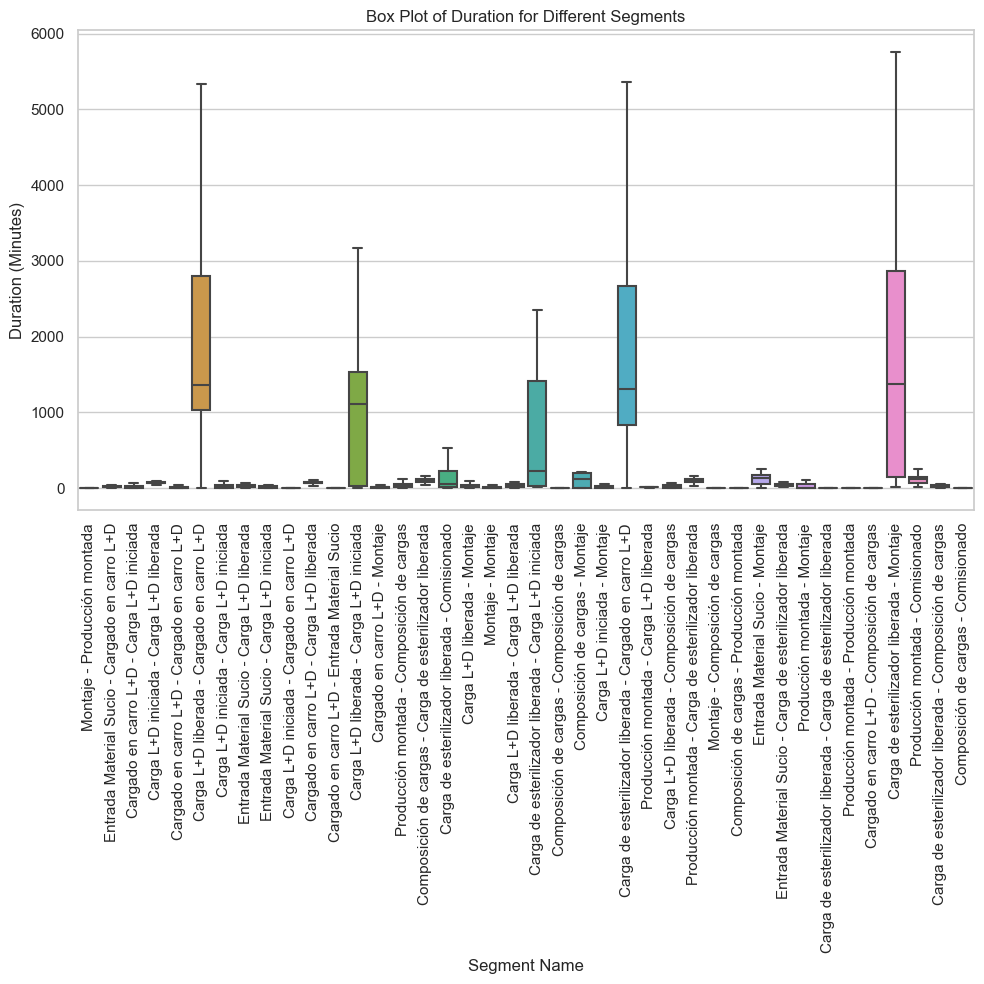

In [43]:
filtered_data = result[~result['segment_name'].isin(filtered_df_excluded)]

# Calculate statistics
grouped_data = filtered_data.groupby('segment_name')['durationMinutes']
statistics = grouped_data.describe(percentiles=[.25, .75])[['std', '25%', '75%']].reset_index()

sns.set(style="whitegrid")

# Create the box plot
plt.figure(figsize=(10, 10))
sns.boxplot(x='segment_name', y='durationMinutes', data=filtered_data, showfliers= False)
plt.xlabel('Segment Name')
plt.ylabel('Duration (Minutes)')
plt.title('Box Plot of Duration for Different Segments')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [44]:
statistics.head()

segment_name          std   25%      75%
0    Carga L+D iniciada - Carga L+D iniciada    41.012936   3.0    38.00
1    Carga L+D iniciada - Carga L+D liberada    82.985935  63.0    77.00
2  Carga L+D iniciada - Cargado en carro L+D    23.266217   0.0     0.00
3               Carga L+D iniciada - Montaje   205.471159   4.0    24.75
4    Carga L+D liberada - Carga L+D iniciada  1344.091088  23.0  1532.50

## Sankey diagram

### 1- For activities related to cases

In [95]:
query = f'''MATCH (r:Run) <- [:HAS_RUN] - (e:Entity)
MATCH (evr1:Event) - [:CORR] -> (r) <- [:CORR] - (evr2:Event)
where not evr1:OnlyKitEvent and not evr2:OnlyKitEvent
match (evr1) - [d:DF] -> (evr2)
with evr1.Activity as er1, evr2.Activity as er2, count(d) as d
RETURN er1, er2, d'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
sddf = pd.DataFrame(records, columns=columns)
sddf.head()

er1                    er2      d
0    Cargado en carro L+D     Carga L+D iniciada  14606
1  Entrada Material Sucio   Cargado en carro L+D  11780
2      Carga L+D liberada                Montaje  10037
3                 Montaje     Producción montada  22609
4      Producción montada  Composición de cargas  19416

In [96]:
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(set(sddf['er1'].tolist() + sddf['er2'].tolist())),
        color="blue"
    ),
    link=dict(
        source=sddf['er1'].map(lambda x: list(set(sddf['er1'].tolist() + sddf['er2'].tolist())).index(x)),
        target=sddf['er2'].map(lambda x: list(set(sddf['er1'].tolist() + sddf['er2'].tolist())).index(x)),
        value=sddf['d']
    ),
    orientation='h'
)])

fig.update_layout(title_text="Activities Flow Sankey Diagram")
fig.show()


### 2- For activities not related to any case / Not valid anymore

In [92]:
query = f'''MATCH (e:Run)
MATCH (eve1:Event) - [:CORR] -> (e) <- [:CORR] - (eve2:Event)
where not eve1:OnlyKitEvent and not eve2:OnlyKitEvent
match (eve1) - [d:DF] -> (eve2)
with eve1.Activity as ev1, eve2.Activity as ev2, count(d) as c
RETURN ev1, ev2, c'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
sddf2 = pd.DataFrame(records, columns=columns)
sddf2.head()

ev1                    ev2      c
0    Cargado en carro L+D     Carga L+D iniciada  14606
1  Entrada Material Sucio   Cargado en carro L+D  11780
2      Carga L+D liberada                Montaje  10037
3                 Montaje     Producción montada  22609
4      Producción montada  Composición de cargas  19416

In [93]:
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(set(sddf2['ev1'].tolist() + sddf2['ev2'].tolist())),
        color="blue"
    ),
    link=dict(
        source=sddf2['ev1'].map(lambda x: list(set(sddf2['ev1'].tolist() + sddf2['ev2'].tolist())).index(x)),
        target=sddf2['ev2'].map(lambda x: list(set(sddf2['ev1'].tolist() + sddf2['ev2'].tolist())).index(x)),
        value=sddf2['c']
    )
)])

fig.update_layout(title_text="Activities Flow Sankey Diagram")
fig.show()

### 3- For all events

In [49]:
query = f'''MATCH  ( e1 : Event ) -[df:DF]-> ( e2 : Event )
with  e1.Activity as e1a, e2.Activity as e2a, count(df) as c
where c > 50
return e1a, e2a, c'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
sddf3 = pd.DataFrame(records, columns=columns)
sddf3.head()

e1a                     e2a      c
0  Entrada Material Sucio    Cargado en carro L+D  11849
1  Entrada Material Sucio  Entrada Material Sucio   1260
2  Entrada Material Sucio                 Montaje     71
3  Entrada Material Sucio      Carga L+D liberada     83
4  Entrada Material Sucio      Carga L+D iniciada     57

In [50]:
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(set(sddf3['e1a'].tolist() + sddf3['e2a'].tolist())),
        color="blue"
    ),
    link=dict(
        source=sddf3['e1a'].map(lambda x: list(set(sddf3['e1a'].tolist() + sddf3['e2a'].tolist())).index(x)),
        target=sddf3['e2a'].map(lambda x: list(set(sddf3['e1a'].tolist() + sddf3['e2a'].tolist())).index(x)),
        value=sddf3['c']
    )
)])

fig.update_layout(title_text="Activities Flow Sankey Diagram")
fig.show()

### 4- Between Cases

In [51]:
query = f'''MATCH p=()-[r:DF_CYCLE]->() 
return distinct (r.EndActivity) as end, r.StartActivity as start, count(r) as c'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
sddf4 = pd.DataFrame(records, columns=columns)
sddf4.head()

end                   start     c
0  Entrada Material Sucio  Entrada Material Sucio  1260
1  Entrada Material Sucio    Cargado en carro L+D    69
2  Entrada Material Sucio                 Montaje     8
3  Entrada Material Sucio      Carga L+D iniciada     2
4    Cargado en carro L+D  Entrada Material Sucio    78

In [52]:
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(set(sddf4['end'].tolist() + sddf4['start'].tolist())),
        color="blue"
    ),
    link=dict(
        source=sddf4['end'].map(lambda x: list(set(sddf4['end'].tolist() + sddf4['start'].tolist())).index(x)),
        target=sddf4['start'].map(lambda x: list(set(sddf4['end'].tolist() + sddf4['start'].tolist())).index(x)),
        value=sddf4['c']
    )
)])

fig.update_layout(title_text="Activities Flow Sankey Diagram")
fig.show()

### 5- Within cases

In [53]:
query = f'''MATCH p=(e1: Event)-[r:DF_CASE]->(e2: Event)
with  e1.Activity as e1a, e2.Activity as e2a, count(r) as c
where c > 50
return e1a, e2a, c'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
sddf5 = pd.DataFrame(records, columns=columns)
sddf5.head()

e1a                   e2a      c
0  Entrada Material Sucio  Cargado en carro L+D  11780
1  Entrada Material Sucio               Montaje     63
2  Entrada Material Sucio    Carga L+D liberada     83
3  Entrada Material Sucio    Carga L+D iniciada     55
4    Cargado en carro L+D    Carga L+D iniciada  14606

In [54]:
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(set(sddf5['e1a'].tolist() + sddf5['e2a'].tolist())),
        color="blue"
    ),
    link=dict(
        source=sddf5['e1a'].map(lambda x: list(set(sddf5['e1a'].tolist() + sddf5['e2a'].tolist())).index(x)),
        target=sddf5['e2a'].map(lambda x: list(set(sddf5['e1a'].tolist() + sddf5['e2a'].tolist())).index(x)),
        value=sddf5['c']
    )
)])

fig.update_layout(title_text="Activities Flow Sankey Diagram")
fig.show()

### 6- For Cases starting from Entrada only

In [55]:
query = f'''MATCH p=(e1: Event)-[r:DF_CYCLE {{StartActivity: 'Entrada Material Sucio'}}]->(e2: Event) 
WITH collect(r.NextCaseID) AS cases_from_entrada
MATCH p=(e1: Event)-[r:DF_CASE]->(e2: Event)
where r.CaseID in cases_from_entrada
with  e1.Activity as e1a, e2.Activity as e2a, count(r) as c
return e1a, e2a, c'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
sddf4 = pd.DataFrame(records, columns=columns)
sddf4.head()

e1a                              e2a      c
0  Entrada Material Sucio             Cargado en carro L+D  10883
1  Entrada Material Sucio  Carga de esterilizador liberada     25
2  Entrada Material Sucio                          Montaje     60
3  Entrada Material Sucio            Composición de cargas     13
4  Entrada Material Sucio               Carga L+D liberada     83

In [56]:
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())),
        color="blue"
    ),
    link=dict(
        source=sddf4['e1a'].map(lambda x: list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())).index(x)),
        target=sddf4['e2a'].map(lambda x: list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())).index(x)),
        value=sddf4['c']
    )
)])

fig.update_layout(title_text="Activities Flow Sankey Diagram")
fig.show()

### 7- For cases starts from Cargado en carro L+D only

In [57]:
query = f'''MATCH p=(e1: Event)-[r:DF_CYCLE {{StartActivity: 'Cargado en carro L+D'}}]->(e2: Event) 
WITH collect(r.NextCaseID) AS cases_from_entrada
MATCH p=(e1: Event)-[r:DF_CASE]->(e2: Event)
where r.CaseID in cases_from_entrada
with  e1.Activity as e1a, e2.Activity as e2a, count(r) as c
return e1a, e2a, c'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
sddf4 = pd.DataFrame(records, columns=columns)
sddf4.head()

e1a                              e2a     c
0  Cargado en carro L+D               Carga L+D iniciada  1423
1  Cargado en carro L+D  Carga de esterilizador liberada    12
2  Cargado en carro L+D             Cargado en carro L+D  2991
3  Cargado en carro L+D               Carga L+D liberada    28
4  Cargado en carro L+D                          Montaje    37

In [58]:
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())),
        color="blue"
    ),
    link=dict(
        source=sddf4['e1a'].map(lambda x: list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())).index(x)),
        target=sddf4['e2a'].map(lambda x: list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())).index(x)),
        value=sddf4['c']
    )
)])

fig.update_layout(title_text="Activities Flow Sankey Diagram")
fig.show()

### 8- For cases starts from Carga L+D iniciada only

In [59]:
query = f'''MATCH p=(e1: Event)-[r:DF_CYCLE {{StartActivity: 'Carga L+D iniciada'}}]->(e2: Event) 
WITH collect(r.NextCaseID) AS cases_from_entrada
MATCH p=(e1: Event)-[r:DF_CASE]->(e2: Event)
where r.CaseID in cases_from_entrada
with  e1.Activity as e1a, e2.Activity as e2a, count(r) as c
return e1a, e2a, c'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
sddf4 = pd.DataFrame(records, columns=columns)
sddf4.head()

e1a                   e2a     c
0  Cargado en carro L+D  Cargado en carro L+D   486
1  Cargado en carro L+D    Carga L+D iniciada    54
2  Cargado en carro L+D    Carga L+D liberada     5
3    Carga L+D iniciada    Carga L+D iniciada  4899
4    Carga L+D iniciada    Carga L+D liberada   210

In [60]:
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())),
        color="blue"
    ),
    link=dict(
        source=sddf4['e1a'].map(lambda x: list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())).index(x)),
        target=sddf4['e2a'].map(lambda x: list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())).index(x)),
        value=sddf4['c']
    )
)])

fig.update_layout(title_text="Activities Flow Sankey Diagram")
fig.show()

### 9- Check for repairs

In [61]:
query = f'''MATCH p=(e1: Event)-[r:DF_CYCLE {{StartActivity: 'Montaje'}}]->(e2: Event) 
WITH collect(r.NextCaseID) AS cases_from_entrada
MATCH p=(e1: Event)-[r:DF_CASE]->(e2: Event)
where r.CaseID in cases_from_entrada
with  e1.Activity as e1a, e2.Activity as e2a, count(r) as c
return e1a, e2a, c'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
sddf4 = pd.DataFrame(records, columns=columns)
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())),
        color="blue"
    ),
    link=dict(
        source=sddf4['e1a'].map(lambda x: list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())).index(x)),
        target=sddf4['e2a'].map(lambda x: list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())).index(x)),
        value=sddf4['c']
    )
)])

fig.update_layout(title_text="Activities Flow Sankey Diagram")
fig.show()

In [62]:
query = f'''MATCH p=(e1: Event)-[r:DF_CYCLE {{EndActivity: 'Montaje'}}]->(e2: Event) 
WITH collect(r.PreviousCaseID) AS cases_from_entrada
MATCH p=(e1: Event)-[r:DF_CASE]->(e2: Event)
where r.CaseID in cases_from_entrada
with  e1.Activity as e1a, e2.Activity as e2a, count(r) as c
return e1a, e2a, c'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
sddf4 = pd.DataFrame(records, columns=columns)
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())),
        color="blue"
    ),
    link=dict(
        source=sddf4['e1a'].map(lambda x: list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())).index(x)),
        target=sddf4['e2a'].map(lambda x: list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())).index(x)),
        value=sddf4['c']
    )
)])

fig.update_layout(title_text="Activities Flow Sankey Diagram")
fig.show()

In [63]:
query = f'''MATCH p=(e1: Event)-[r:DF_CYCLE {{EndActivity: 'Producción montada'}}]->(e2: Event) 
WITH collect(r.PreviousCaseID) AS cases_from_entrada
MATCH p=(e1: Event)-[r:DF_CASE]->(e2: Event)
where r.CaseID in cases_from_entrada
with  e1.Activity as e1a, e2.Activity as e2a, count(r) as c
return e1a, e2a, c'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
sddf4 = pd.DataFrame(records, columns=columns)
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())),
        color="blue"
    ),
    link=dict(
        source=sddf4['e1a'].map(lambda x: list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())).index(x)),
        target=sddf4['e2a'].map(lambda x: list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())).index(x)),
        value=sddf4['c']
    )
)])

fig.update_layout(title_text="Activities Flow Sankey Diagram")
fig.show()

In [64]:
query = f'''MATCH p=(e1: Event)-[r:DF_CYCLE {{StartActivity: 'Comisionado'}}]->(e2: Event) 
WITH collect(r.NextCaseID) AS cases_from_entrada
MATCH p=(e1: Event)-[r:DF_CASE]->(e2: Event)
where r.CaseID in cases_from_entrada
with  e1.Activity as e1a, e2.Activity as e2a, count(r) as c
return e1a, e2a, c'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
sddf4 = pd.DataFrame(records, columns=columns)
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())),
        color="blue"
    ),
    link=dict(
        source=sddf4['e1a'].map(lambda x: list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())).index(x)),
        target=sddf4['e2a'].map(lambda x: list(set(sddf4['e1a'].tolist() + sddf4['e2a'].tolist())).index(x)),
        value=sddf4['c']
    )
)])

fig.update_layout(title_text="Activities Flow Sankey Diagram")
fig.show()

In [65]:
#query = f'''
#match (en:Entity) <- [:HAS_UNIT] - (k:Kit)
#where k.isLended <> True or k.isLended is null
#match (r:Run) - [:HAS_RUN] -> (en)
#Match (e:Event)
#where e.CaseID is not null and ((e) - [:CORR] -> (r) or (e) - [:CORR] -> (en))
#return e.CaseID, e.Activity, e.Nombre, e.KitID, e.Usuario as resource, e.timestamp, e.`Código`, e.NS '''
#result = session.run(query)
#records = [record.values() for record in result]
#columns = result.keys()
#df = pd.DataFrame(records, columns=columns)
#df['e.timestamp'] = pd.to_datetime(df['e.timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
#df.head()

In [66]:
#df.count()

## check containers workflow

In [79]:
query = f'''
match (k:Kit {{isWashingMachineContainer: True}}) - [:HAS_UNIT] -> (en:Entity) - [:HAS_RUN] -> (r:Run) <- [:CORR] - (e:Event)
where not e:OnlyKitEvent and e.CaseID is not null
return e.CaseID as CaseID, e.Activity as Activity, e.Nombre as Nombre, e.KitID as KitID, e.Usuario as resource, e.timestamp as timestamp, e.`Código` as Codigo, e.NS as NS 
'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
df = pd.DataFrame(records, columns=columns)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
df.head()

CaseID              Activity                       Nombre  \
0  CONT-QUI.CP-1-CN19978  Cargado en carro L+D  *QUIROFANO C.PEDIATRICA BTC   
1  CONT-QUI.CP-1-CN19978    Carga L+D iniciada  *QUIROFANO C.PEDIATRICA BTC   
2  CONT-QUI.CP-1-CN19978    Carga L+D liberada  *QUIROFANO C.PEDIATRICA BTC   
3  CONT-QUI.CP-1-CN19978    Carga L+D liberada  *QUIROFANO C.PEDIATRICA BTC   
4  CONT-QUI.CP-1-CN19978    Carga L+D iniciada  *QUIROFANO C.PEDIATRICA BTC   

           KitID resource                 timestamp       Codigo  NS  
0  CONT-QUI.CP-1       CM 2022-02-15 15:42:00+00:00  CONT-QUI.CP   1  
1  CONT-QUI.CP-1       PN 2022-02-15 15:49:00+00:00  CONT-QUI.CP   1  
2  CONT-QUI.CP-1       VA 2022-02-15 16:55:00+00:00  CONT-QUI.CP   1  
3  CONT-QUI.CP-1       EH 2022-02-17 14:02:00+00:00  CONT-QUI.CP   1  
4  CONT-QUI.CP-1      MMF 2022-02-17 13:06:00+00:00  CONT-QUI.CP   1

In [80]:
event_log = pm4py.format_dataframe(df, case_id='CaseID', activity_key='Activity', timestamp_key='timestamp')
event_log = pm4py.convert_to_event_log(event_log)

In [81]:
len(pm4py.get_variants_as_tuples(event_log))

126

In [82]:
dfStart = pd.DataFrame(list(pm4py.get_start_activities(event_log).items()), columns=['Activity', 'Count'])
dfStart.head()

Activity  Count
0  Entrada Material Sucio   2548
1    Cargado en carro L+D    203
2      Carga L+D iniciada     15

In [83]:
dfEnd = pd.DataFrame(list(pm4py.get_end_activities(event_log).items()), columns=['Activity', 'Count'])
dfEnd.head()

Activity  Count
0    Carga L+D liberada   2606
1    Carga L+D iniciada    106
2  Cargado en carro L+D     54

In [84]:
arrival_rate = stats.get_case_arrival_average(event_log) 
print("Average arrival rate in minutes:", arrival_rate / 60)

Average arrival rate in minutes: 46.57287522603978


In [85]:
median_case_duration = case_statistics.get_median_case_duration(event_log) 
print ('median_case_duration in minutes:', median_case_duration / 60)

median_case_duration in minutes: 95.0


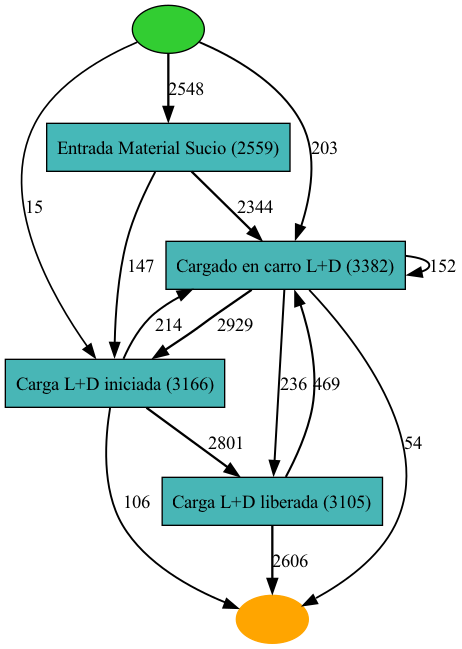

In [86]:
heu_net = pm4py.discover_heuristics_net(event_log, dependency_threshold=0.9)
pm4py.view_heuristics_net(heu_net)

In [87]:
df = pm4py.convert_to_dataframe(event_log)
df.head()

concept:name             Nombre            KitID resource  \
0  Entrada Material Sucio  *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1       ER   
1    Cargado en carro L+D  *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1       ER   
2      Carga L+D iniciada  *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1      MMF   
3      Carga L+D liberada  *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1      MCE   
4  Entrada Material Sucio  *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1       LI   

             time:timestamp         Codigo  NS  @@index  \
0 2022-01-28 13:10:00+00:00  CONT-CCEE.ALE   1    10322   
1 2022-01-28 13:18:00+00:00  CONT-CCEE.ALE   1    10319   
2 2022-01-28 13:34:00+00:00  CONT-CCEE.ALE   1    10320   
3 2022-01-28 14:39:00+00:00  CONT-CCEE.ALE   1    10321   
4 2022-02-02 13:13:00+00:00  CONT-CCEE.ALE   1    10339   

         case:concept:name  
0  CONT-CCEE.ALE-1-CN11541  
1  CONT-CCEE.ALE-1-CN11541  
2  CONT-CCEE.ALE-1-CN11541  
3  CONT-CCEE.ALE-1-CN11541  
4  CONT-CCEE.ALE-1-CN13746

In [88]:
segments = []
df = df.sort_values(['case:concept:name', 'time:timestamp', 'concept:name'])

result = pd.concat([df, df.shift(-1)], axis=1)
result.columns = [str(i) + str(k // (len(df.columns))) for k, i in enumerate(result.columns)]
result = result[result['case:concept:name0'] == result['case:concept:name1']]

result['segment_name'] = result['concept:name0'] + ' - ' + result['concept:name1']
result.drop(['concept:name0', 'case:concept:name1', 'concept:name1'], axis=1, inplace=True)
result.columns = ['start_' + i.split('0')[0] if '0' in i else ('end_' + i.split('1')[0] if '1' in i else i) for i in result.columns]

segments = result['segment_name'].unique()
result.head()

start_Nombre      start_KitID start_resource  \
0  *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1             ER   
1  *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1             ER   
2  *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1            MMF   
4  *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1             LI   
5  *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1             EH   

       start_time:timestamp   start_Codigo  start_NS  start_@@index  \
0 2022-01-28 13:10:00+00:00  CONT-CCEE.ALE         1          10322   
1 2022-01-28 13:18:00+00:00  CONT-CCEE.ALE         1          10319   
2 2022-01-28 13:34:00+00:00  CONT-CCEE.ALE         1          10320   
4 2022-02-02 13:13:00+00:00  CONT-CCEE.ALE         1          10339   
5 2022-02-02 13:29:00+00:00  CONT-CCEE.ALE         1          10340   

   start_case:concept:name         end_Nombre        end_KitID end_resource  \
0  CONT-CCEE.ALE-1-CN11541  *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1           ER   
1  CONT-CCEE.ALE-1-CN11541  *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1          MMF   
2  CONT-CCEE.ALE-1-CN11541  *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1          MCE   
4  CONT-CCEE.ALE-1-CN13746  *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1           EH   
5  CONT-CCEE.ALE-1-CN13746  *CCEE ALERGIAS 1B  CONT-CCEE.ALE-1           EH   

         end_time:timestamp     end_Codigo  end_NS  end_@@index  \
0 2022-01-28 13:18:00+00:00  CONT-CCEE.ALE     1.0      10319.0   
1 2022-01-28 13:34:00+00:00  CONT-CCEE.ALE     1.0      10320.0   
2 2022-01-28 14:39:00+00:00  CONT-CCEE.ALE     1.0      10321.0   
4 2022-02-02 13:29:00+00:00  CONT-CCEE.ALE     1.0      10340.0   
5 2022-02-02 13:31:00+00:00  CONT-CCEE.ALE     1.0      10342.0   

                                    segment_name  
0  Entrada Material Sucio - Cargado en carro L+D  
1      Cargado en carro L+D - Carga L+D iniciada  
2        Carga L+D iniciada - Carga L+D liberada  
4  Entrada Material Sucio - Cargado en carro L+D  
5    Cargado en carro L+D - Cargado en carro L+D

In [89]:
result['durationMinutes'] = (result['end_time:timestamp'] - result['start_time:timestamp']).dt.total_seconds() / 60 

In [90]:
# Calculate Q1, Q3, and IQR
Q1 = result.groupby('segment_name')['durationMinutes'].quantile(0.25)
Q3 = result.groupby('segment_name')['durationMinutes'].quantile(0.75)
IQR = Q3 - Q1

# Calculate lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
result_filtered = result[~result.apply(lambda x: (x['durationMinutes'] < lower_bound[x['segment_name']]) or 
                                              (x['durationMinutes'] > upper_bound[x['segment_name']]), axis=1)]

# Group by segment_name and calculate statistics
grouped = result_filtered.groupby('segment_name')['durationMinutes'].describe()

grouped.sort_values('count', ascending=False).head()

count         mean  \
segment_name                                                         
Cargado en carro L+D - Carga L+D iniciada      2584.0    12.454334   
Carga L+D iniciada - Carga L+D liberada        2445.0    66.885890   
Entrada Material Sucio - Cargado en carro L+D  1984.0    12.023690   
Carga L+D liberada - Cargado en carro L+D       440.0  1749.452273   
Cargado en carro L+D - Carga L+D liberada       327.0    64.990826   

                                                       std   min    25%  \
segment_name                                                              
Cargado en carro L+D - Carga L+D iniciada        12.486254   1.0    2.0   
Carga L+D iniciada - Carga L+D liberada           8.371273  47.0   61.0   
Entrada Material Sucio - Cargado en carro L+D     8.161626   1.0    6.0   
Carga L+D liberada - Cargado en carro L+D      1544.110297   0.0  685.5   
Cargado en carro L+D - Carga L+D liberada        14.490421  24.0   57.0   

                                                  50%     75%     max  
segment_name                                                           
Cargado en carro L+D - Carga L+D iniciada         8.0    19.0    53.0  
Carga L+D iniciada - Carga L+D liberada          66.0    72.0    93.0  
Entrada Material Sucio - Cargado en carro L+D    10.0    16.0    41.0  
Carga L+D liberada - Cargado en carro L+D      1352.0  2717.0  5733.0  
Cargado en carro L+D - Carga L+D liberada        65.0    74.0   103.0